<a href="https://colab.research.google.com/github/sararosengithub/Wepan_presentation_analysis/blob/main/Weapon_Presentation_Analysis_iypnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import csv
from pprint import pprint
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import os
from io import StringIO
import csv
import seaborn as sns


In [2]:
def parse_event_file(file_path):
    """
    Parses an event file with dynamic headers.

    Args:
        file_path (str): The path to the .event file.

    Returns:
        tuple: (header_definitions, events_data)
               header_definitions (dict): A dictionary mapping (category, event_type)
                                          tuples to a list of their field names.
               events_data (list): A list of dictionaries, where each dictionary
                                   represents an event with its parsed fields.
    """
    header_definitions = {}
    events_data = []

    with open(file_path, 'r') as f:
        # Using csv.reader to handle potential commas within quoted fields, though
        # your example doesn't show quotes, it's a good practice.
        # If you are certain there are no quoted fields with commas, line.split(',') is fine.
        reader = csv.reader(f)
        for row_parts in reader:
            if not row_parts:  # Skip empty lines
                continue

            if row_parts[0] == "HEADER":
                category = row_parts[1]
                event_sub_type = row_parts[2]
                field_names = row_parts[3:]
                header_definitions[(category, event_sub_type)] = field_names
            else:
                # This is an event data row
                timestamp = int(row_parts[0]) # Timestamps are typically integers
                category = row_parts[1]
                event_sub_type = row_parts[2]
                values = row_parts[3:]

                event_record = {
                    "timestamp": timestamp,
                    "category": category,
                    "event_type": event_sub_type  # Renaming to avoid clash if 'event_type' is a field
                }

                # Get the field names for this event type
                field_names = header_definitions.get((category, event_sub_type))

                if field_names:
                    if len(values) == len(field_names):
                        for i, field_name in enumerate(field_names):
                            event_record[field_name] = values[i]
                    else:
                        print(f"Warning: Mismatch in field count for event {category}/{event_sub_type} at timestamp {timestamp}.")
                        print(f"  Expected {len(field_names)} fields ({field_names}), got {len(values)} ({values}).")
                        # Store raw values if mismatch, or handle as error
                        for i, field_name in enumerate(field_names):
                            if i < len(values):
                                event_record[field_name] = values[i]
                            else:
                                event_record[field_name] = None # Or some placeholder
                else:
                    print(f"Warning: No header definition found for event {category}/{event_sub_type} at timestamp {timestamp}.")
                    # Store raw values if no header found
                    event_record['raw_values'] = values

                events_data.append(event_record)

    return header_definitions, events_data

In [3]:
file_path = "/content/drive/MyDrive/Weapon_presentation/2024.11.25.14.36.51.scenario1.event.evt"
headers, events = parse_event_file(file_path)

print("--- Header Definitions ---")
pprint(headers)

print("\n--- Parsed Events (showing first few and specific ones) ---")
# Print the first 3 events
for i in range(min(3, len(events))):
    pprint(events[i])
    print("-" * 20)

# Example: Find and print all 'drill_shot' events
print("\n--- 'drill_shot' events ---")
for event in events:
    if event.get("event_type") == "drill_shot":
        pprint(event)
        print("-" * 20)

# Example: Find and print all 'target_state_change' events
print("\n--- 'target_state_change' events ---")
for event in events:
    if event.get("event_type") == "target_state_change":
        pprint(event)
        print("-" * 20)

# Example: Find and print all 'drill_metrics' events
print("\n--- 'drill_metrics' events ---")
for event in events:
    if event.get("event_type") == "drill_metrics":
        pprint(event)
        print("-" * 20)

--- Header Definitions ---
{('drill', 'drill_end'): ['drill_uid', 'duration', 'result', 'error'],
 ('drill', 'drill_metrics'): ['drill_uid',
                              'hit_score',
                              'speed',
                              'hit_accuracy',
                              'hit_ratio',
                              'hit_factor'],
 ('drill', 'drill_shot'): ['shot_index',
                           'weapon_type',
                           'ballistic_model_type',
                           'bullet_type',
                           'bullet_mass',
                           'bullet_diameter',
                           'bullet_muzzle_velocity',
                           'bullet_drag_coefficient',
                           'weapon_zeroing_distance',
                           'is_valid_hit',
                           'hit_type',
                           'hit_name',
                           'hit_zone_center_x',
                           'hit_zone_center_y',
 

In [9]:

# 1. Initialize a dictionary to hold structured drill data
#    Key: drill_uid, Value: dictionary of drill properties
drills_for_analysis = {}

# 2. First pass: Collect drill_start and drill_end events
for event in events:
    event_timestamp = int(event['timestamp'])

    if event['event_type'] == 'drill_start':
        drill_uid = event['drill_uid']
        if drill_uid not in drills_for_analysis:
            drills_for_analysis[drill_uid] = {
                'drill_uid': drill_uid,
                'start_time': event_timestamp,
                'end_time': None,
                'first_shot': None
            }
        else:
            # This case (duplicate drill_start for same UID) should ideally not happen
            # or needs specific handling rules. Overwriting or logging.
            print(f"Warning: Duplicate drill_start for UID {drill_uid}. Using latest: {event_timestamp}")

    elif event['event_type'] == 'drill_end':
        drill_uid = event['drill_uid']
        if drill_uid in drills_for_analysis:
            drills_for_analysis[drill_uid]['end_time'] = event_timestamp
        else:
            # Drill_end event without a preceding drill_start. This is an anomaly.
            print(f"Warning: Found drill_end for UID {drill_uid} without a corresponding drill_start. Ignoring.")

In [10]:
# 3. Second pass: Associate drill_shot events with their respective drills
#    Shots must fall within the start_time and end_time of a drill.
all_shot_events = [event for event in events if event['event_type'] == 'drill_shot' and event['shot_index']=='0']
all_shot_events.sort(key=lambda x: int(x['timestamp'])) # Sort shots by time

for shot_event in all_shot_events:
    shot_time = int(shot_event['timestamp'])

    assigned_to_drill = False
    for drill_uid, drill_info in drills_for_analysis.items():
        if drill_info['start_time'] is None: # Should not happen if start was processed
            continue

        # A shot belongs to a drill if:
        # 1. shot_time is >= drill_start_time
        # 2. EITHER drill_end_time is not set (drill ongoing / end event missing)
        #    OR shot_time is <= drill_end_time
        # For this task, we are interested in shots *before* or *at* drill_end.
        is_after_start = shot_time >= drill_info['start_time']
        is_before_end = drill_info['end_time'] is None or shot_time <= drill_info['end_time']

        if is_after_start and is_before_end:
            drill_info['first_shot'] = shot_time
            assigned_to_drill = True
            break

    if not assigned_to_drill:
        print(f"Warning: Shot at {shot_time} could not be assigned to any active drill period.")


print("\n--- Drills Prepared for Analysis ---")
pprint(drills_for_analysis)



--- Drills Prepared for Analysis ---
{'Assessment/double_tap': {'drill_uid': 'Assessment/double_tap',
                           'end_time': 1732538232343,
                           'first_shot': 1732538232140,
                           'start_time': 1732538230160},
 'Assessment/el_presidente': {'drill_uid': 'Assessment/el_presidente',
                              'end_time': 1732538290137,
                              'first_shot': 1732538279584,
                              'start_time': 1732538275303},
 'Assessment/failure': {'drill_uid': 'Assessment/failure',
                        'end_time': 1732538244473,
                        'first_shot': 1732538243621,
                        'start_time': 1732538241360},
 'Assessment/forty_five': {'drill_uid': 'Assessment/forty_five',
                           'end_time': 1732538267786,
                           'first_shot': 1732538267040,
                           'start_time': 1732538264717},
 'Assessment/head_shot': {'drill_u

In [6]:


frame_df = pd.read_csv("/content/drive/MyDrive/Weapon_presentation/2024.11.25.14.36.51.scenario1.frame.csv")


In [ ]:
# # 2. Iterate Through Drills
# for drill_uid, drill_data in drills_data_map.items():
#     T_drill_start = drill_data['start_time']

In [ ]:
    # # --- Thresholds (These need careful tuning based on actual data!) ---
    # IDLE_VELOCITY_THRESHOLD = 0.05  # m/s (example: 5 cm/s)
    # MOVEMENT_VELOCITY_THRESHOLD = 0.15 # m/s (example: 15 cm/s, for presentation start)
    # SUSTAINED_MOVEMENT_FRAMES = 3   # Min frames of continuous movement to count as start
    # MIN_Y_LIFT_FOR_START = 0.03     # meters (e.g., 3cm minimum upward Y movement from idle)

    # STABILIZATION_VELOCITY_THRESHOLD = 0.1 # m/s (example: 10 cm/s, for presentation end)
    # SUSTAINED_STABILIZATION_FRAMES = 3 # Min frames of low velocity for stabilization

    # CURVE_LINE_RATIO_THRESHOLD = 1.15 # motion_length / direct_distance
    # CURVE_PUSH_LATERAL_DEV_RATIO = 0.25 # max_lateral_dev / direct_distance_xz
    # CURVE_SWING_LATERAL_DEV_RATIO = 0.35 # max_lateral_dev / direct_distance_xz
    # MAX_WOBBLE_DEVIATION_M = 0.05
    # VERTICAL_DEVIATION_THRESHOLD_M = 0.05
    # LATERAL_DEVIATION_THRESHOLD_M = 0.05

    # WEAPON_POS_COLS = ['weapon_muzzle_position_x', 'weapon_muzzle_position_y', 'weapon_muzzle_position_z']
    # # --- End Thresholds ---

In [36]:
def plot_drill_presentation(scenario_id, drill_uid, trajectory_df, T_pres_start, T_pres_end, weapon_pos_cols, curve_type, base_output_dir="plots"):
    """
    Creates and saves a 2D plot (XZ and YZ views) of the weapon presentation path.
    """
    if trajectory_df.empty or len(trajectory_df) < 2:
        print(f"  Plotting: No trajectory data to plot for drill {drill_uid}.")
        return

    # Create scenario-specific output directory
    output_dir = os.path.join(base_output_dir, f"scenario_{scenario_id}")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    # Ensure weapon position columns are numeric
    for col in weapon_pos_cols:
        trajectory_df[col] = pd.to_numeric(trajectory_df[col], errors='coerce')
    trajectory_df = trajectory_df.dropna(subset=weapon_pos_cols) # Drop rows if conversion failed

    if trajectory_df.empty or len(trajectory_df) < 2:
        print(f"  Plotting: Not enough valid numeric trajectory data after conversion for drill {drill_uid}.")
        return

    x_col, y_col, z_col = weapon_pos_cols[0], weapon_pos_cols[1], weapon_pos_cols[2]

    path_x = trajectory_df[x_col]
    path_y = trajectory_df[y_col]
    path_z = trajectory_df[z_col]

    # Find the actual start and end points on the plotted trajectory
    # (T_pres_start and T_pres_end are timestamps, need to map to trajectory points)
    start_point_data = trajectory_df[trajectory_df['timestamp'] == T_pres_start]
    end_point_data = trajectory_df[trajectory_df['timestamp'] == T_pres_end]

    start_x, start_y, start_z = None, None, None
    if not start_point_data.empty:
        start_x = start_point_data[x_col].iloc[0]
        start_y = start_point_data[y_col].iloc[0]
        start_z = start_point_data[z_col].iloc[0]
    elif not trajectory_df.empty: # Fallback to first point of trajectory if exact timestamp match fails
        start_x, start_y, start_z = path_x.iloc[0], path_y.iloc[0], path_z.iloc[0]


    end_x, end_y, end_z = None, None, None
    if not end_point_data.empty:
        end_x = end_point_data[x_col].iloc[0]
        end_y = end_point_data[y_col].iloc[0]
        end_z = end_point_data[z_col].iloc[0]
    elif not trajectory_df.empty: # Fallback to last point
        end_x, end_y, end_z = path_x.iloc[-1], path_y.iloc[-1], path_z.iloc[-1]


    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f"Drill: {drill_uid} - Presentation Path (Type: {curve_type})", fontsize=16)

    # Top-Down View (XZ plane)
    axs[0].plot(path_x, path_z, marker='.', linestyle='-', label="Path")
    if start_x is not None:
        axs[0].plot(start_x, start_z, 'go', markersize=10, label="Start (T_pres_start)")
    if end_x is not None:
        axs[0].plot(end_x, end_z, 'ro', markersize=10, label="End (T_pres_end)")
    axs[0].set_xlabel("X-coordinate (meters)")
    axs[0].set_ylabel("Z-coordinate (meters, Forward)")
    axs[0].set_title("Top-Down View (XZ Plane)")
    axs[0].legend()
    axs[0].grid(True)
    axs[0].axis('equal') # Equal scaling for X and Z

    # Side View (YZ plane)
    axs[1].plot(path_z, path_y, marker='.', linestyle='-', label="Path") # Z on X-axis for intuitive "forward"
    if start_z is not None:
        axs[1].plot(start_z, start_y, 'go', markersize=10, label="Start (T_pres_start)")
    if end_z is not None:
        axs[1].plot(end_z, end_y, 'ro', markersize=10, label="End (T_pres_end)")
    axs[1].set_xlabel("Z-coordinate (meters, Forward)")
    axs[1].set_ylabel("Y-coordinate (meters, Up)")
    axs[1].set_title("Side View (ZY Plane)")
    axs[1].legend()
    axs[1].grid(True)
    axs[1].axis('equal') # Equal scaling for Z and Y

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle

    # Sanitize drill_uid for filename
    safe_drill_uid = "".join(c if c.isalnum() else "_" for c in drill_uid)
    plot_filename = os.path.join(output_dir, f"drill_{safe_drill_uid}_presentation.png")
    try:
        plt.savefig(plot_filename)
        print(f"  Plot saved: {plot_filename}")
    except Exception as e:
        print(f"  Error saving plot {plot_filename}: {e}")
    plt.close(fig) # Close the figure to free memory


In [37]:
def classify_presentation_curve(trajectory_df, weapon_pos_cols, motion_length_m, direct_dist_m, curve_thresholds):
    """
    Classifies the curve shape of the presentation based on revised definitions.
    Args:
        trajectory_df (pd.DataFrame): DataFrame of the presentation trajectory.
        weapon_pos_cols (list): Names of X, Y, Z columns.
        motion_length_m (float): Total path length of the trajectory in meters.
        direct_dist_m (float): Straight-line distance between start and end of trajectory in meters.
        curve_thresholds (dict): Dictionary containing thresholds like:
            'LINE_RATIO_THRESHOLD': Max ratio of motion_length / direct_dist for a "line".
            'VERTICAL_DEVIATION_THRESHOLD_M': Max deviation in Y (meters) from direct path to still be "line".
                                            Also used to quantify "above/below" for push/swing.
            'LATERAL_DEVIATION_THRESHOLD_M': Max deviation in X (meters) from direct path (in XZ) to be "line".
                                           Also used to quantify "side-to-side" for push/swing.
    Returns:
        str: "line", "push", "swing", or "other".
    """
    VERTICAL_DEVIATION_THRESHOLD_M = curve_thresholds['VERTICAL_DEVIATION_THRESHOLD_M']
    LATERAL_DEVIATION_THRESHOLD_M = curve_thresholds['LATERAL_DEVIATION_THRESHOLD_M']

    if trajectory_df.empty or len(trajectory_df) < 2:
        return "other"

    positions = trajectory_df[weapon_pos_cols].values
    P_start = positions[0]
    P_end = positions[-1]

    # 1. Check for "Line"
    is_line_candidate = False
    if direct_dist_m < 0.01: # Very short movement, essentially a point or tiny adjustment
        is_line_candidate = True
    elif (motion_length_m / direct_dist_m) < curve_thresholds['LINE_RATIO_THRESHOLD']:
        is_line_candidate = True

    if is_line_candidate:
        # For a line, deviations in all dimensions should be small.
        # We'll check max deviation from the 3D line P_start to P_end.
        max_total_deviation_m = 0.0
        if direct_dist_m > 1e-6: # Avoid division by zero if P_start and P_end are same
            v = P_end - P_start # Vector from start to end
            v_mag_sq = np.dot(v, v)
            for P_point in positions[1:-1]: # Check intermediate points
                # vector from P_start to P_point
                w = P_point - P_start
                # projection of w onto v: t = dot(w,v) / dot(v,v)
                # P_proj = P_start + t*v is the point on the line closest to P_point
                # distance = norm(P_point - P_proj)
                t = np.dot(w, v) / v_mag_sq
                if 0 <= t <= 1: # Projection falls within the segment
                    P_proj = P_start + t * v
                    deviation = euclidean(P_point, P_proj)
                    if deviation > max_total_deviation_m:
                        max_total_deviation_m = deviation
                else: # Projection is outside segment, check distance to P_start or P_end
                    dev_to_start = euclidean(P_point, P_start)
                    dev_to_end = euclidean(P_point, P_end)
                    deviation = min(dev_to_start, dev_to_end) # A bit of a simplification here
                    if deviation > max_total_deviation_m:
                        max_total_deviation_m = deviation


        # If max_total_deviation is small enough, it's a line.
        # This threshold needs to be set carefully. Let's use a combined threshold.
        # The LINE_RATIO_THRESHOLD already covers overall path length.
        # This checks for "wobbles" even if total length is okay.
        if max_total_deviation_m < curve_thresholds.get('MAX_WOBBLE_DEVIATION_M', 0.05): # e.g., 5cm wobble
             return "line"
        # else it was a candidate but too wobbly, falls through to push/swing/other


    # 2. If not a "Line", analyze for "Pushing" or "Swinging" based on deviations
    # We need to analyze deviations relative to the ideal line P_start -> P_end

    # Vertical deviation (Y-axis)
    # For each point in trajectory, calculate its Y vs the Y of the ideal line at that XZ projection
    # A simpler approach: find the point of maximum upward and downward Y deviation from the line.
    max_y_above_line = 0.0 # Max positive (Y_actual - Y_on_line)
    max_y_below_line = 0.0 # Max positive (Y_on_line - Y_actual) where Y_actual < Y_on_line

    # Lateral deviation (X-axis, relative to XZ line)
    max_x_deviation_abs = 0.0 # Max absolute X deviation from XZ line

    if direct_dist_m > 1e-6: # Only if there's a defined line
        # Vector from P_start to P_end
        direction_vector = P_end - P_start

        for P_current in positions[1:-1]: # Intermediate points
            # Parameter t for projection onto the line P_start -> P_end
            # t = dot(P_current - P_start, direction_vector) / dot(direction_vector, direction_vector)
            # P_on_line = P_start + t * direction_vector

            # We are interested in t relative to the *overall progress* along the line.
            # A simple way to estimate progress is by time or index if sampling is regular.
            # Or, project P_current onto the line to find the closest point P_on_line.

            # Vector from P_start to P_current
            w = P_current - P_start
            # Projection parameter (t)
            t = np.dot(w, direction_vector) / np.dot(direction_vector, direction_vector)

            # Clamp t to [0, 1] to ensure P_on_line is on the segment for deviation checks
            t_clamped = max(0, min(1, t))
            P_on_line_segment = P_start + t_clamped * direction_vector

            # Vertical deviation
            y_actual = P_current[1]
            y_on_line = P_on_line_segment[1]
            vertical_diff = y_actual - y_on_line
            if vertical_diff > 0: # Actual path is above the direct line's Y
                max_y_above_line = max(max_y_above_line, vertical_diff)
            else: # Actual path is at or below the direct line's Y
                max_y_below_line = max(max_y_below_line, abs(vertical_diff))


            # Lateral (X) deviation in XZ plane
            # Line in XZ plane: P_start_xz -> P_end_xz
            P_start_xz = P_start[[0, 2]]
            P_end_xz = P_end[[0, 2]]
            P_current_xz = P_current[[0, 2]]

            if not np.allclose(P_start_xz, P_end_xz):
                A = P_end_xz[1] - P_start_xz[1]   # dz
                B = P_start_xz[0] - P_end_xz[0]   # -dx
                C = P_end_xz[0] * P_start_xz[1] - P_end_xz[1] * P_start_xz[0] # x2*z1 - z2*x1
                if not (A == 0 and B == 0):
                    dist_to_xz_line = abs(A * P_current_xz[0] + B * P_current_xz[1] + C) / np.sqrt(A**2 + B**2)
                    max_x_deviation_abs = max(max_x_deviation_abs, dist_to_xz_line)

    # Decision logic based on deviations:
    # These thresholds define what "significant" deviation means.
    VERTICAL_DEV_THRESH = VERTICAL_DEVIATION_THRESHOLD_M
    LATERAL_DEV_THRESH = LATERAL_DEVIATION_THRESHOLD_M

    is_push_y = max_y_above_line > VERTICAL_DEV_THRESH
    is_swing_y = max_y_below_line > VERTICAL_DEV_THRESH # "Below" optimal line (relative to direct path)
    is_side_to_side_x = max_x_deviation_abs > LATERAL_DEV_THRESH

    # Combine:
    # The task implies Pushing is "above" OR "side-to-side"
    # The task implies Swinging is "below" OR "side-to-side"
    # This can lead to ambiguity if both Y deviation and X deviation occur.
    # Let's prioritize the Y-deviation character if strong, then X.

    if is_push_y and not is_swing_y: # Clearly above
        return "push"
    if is_swing_y and not is_push_y: # Clearly below
        return "swing"

    # If both Y deviations are present or neither are dominant over the threshold,
    # or if only X deviation is significant:
    if is_side_to_side_x:
        # If it had a Y characteristic too, we might want to be more nuanced.
        # For now, if side-to-side is the dominant or only feature (after line check):
        # The task description for push/swing includes "side-to-side" for both.
        # This is where it gets ambiguous if we don't have a primary Y characteristic.
        # Let's make a choice: if significant side-to-side, and Y wasn't clearly push/swing:
        if max_y_above_line > max_y_below_line and max_y_above_line > VERTICAL_DEV_THRESH * 0.5: # Slight tendency to be above
            return "push" # Or "other_side_push"
        elif max_y_below_line > max_y_above_line and max_y_below_line > VERTICAL_DEV_THRESH * 0.5: # Slight tendency to be below
            return "swing" # Or "other_side_swing"
        else: # No clear Y tendency with the side-to-side, or Y deviations are small.
              # The task is ambiguous here. Defaulting to "swing" if only side-to-side prominent,
              # as "swing" often implies a broader arc. Or could be "other".
            return "swing" # Or "other_lateral" if you want a distinct category

    # If it wasn't a line, and didn't meet push/swing criteria significantly:
    return "other"

In [38]:
def calculate_presentation_speed(T_pres_start, T_pres_end):
    """Calculates the speed (duration) of the presentation."""
    if T_pres_start is None or T_pres_end is None:
        return None
    return T_pres_end - T_pres_start

def calculate_presentation_motion(trajectory_df, weapon_pos_cols):
    """
    Calculates the total path length (motion) and direct distance of the presentation.
    Returns:
        tuple: (motion_length_m, direct_dist_m) in meters.
    """
    if trajectory_df.empty or len(trajectory_df) < 2:
        return 0.0, 0.0

    motion_length_m = 0.0
    positions = trajectory_df[weapon_pos_cols].values
    for i in range(len(positions) - 1):
        p1 = positions[i]
        p2 = positions[i+1]
        motion_length_m += euclidean(p1, p2)

    P_start_traj = positions[0]
    P_end_traj = positions[-1]
    direct_dist_m = euclidean(P_start_traj, P_end_traj)

    return motion_length_m, direct_dist_m


# --- PRESENTATION WINDOW AND TRAJECTORY FINDER ---
def find_presentation_window_and_trajectory(drill_frames_segment_with_velocity, weapon_pos_cols, T_drill_start_ts, window_thresholds):
    """
    Finds T_pres_start, T_pres_end and extracts the trajectory_df.
    `drill_frames_segment_with_velocity` should already have 'velocity_mag' and 'velocity_xyz' columns.
    Returns:
        tuple: (T_pres_start, T_pres_end, trajectory_df) or (None, None, pd.DataFrame()) if failed.
    """
    df = drill_frames_segment_with_velocity # Already a copy from caller

    T_pres_start = None
    idx_pres_start = -1
    initial_y_position_at_drill_start = df.loc[df['timestamp'] == T_drill_start_ts, weapon_pos_cols[1]].iloc[0] \
                                       if not df[df['timestamp'] == T_drill_start_ts].empty else df.iloc[0][weapon_pos_cols[1]]


    for i in range(len(df) - window_thresholds['SUSTAINED_MOVEMENT_FRAMES'] + 1):
        current_segment = df.iloc[i : i + window_thresholds['SUSTAINED_MOVEMENT_FRAMES']]
        if not (current_segment['velocity_mag'] >= window_thresholds['MOVEMENT_VELOCITY_THRESHOLD']).all():
            continue

        y_at_potential_start = df.iloc[i][weapon_pos_cols[1]]
        y_at_end_of_sustained_move = df.iloc[i + window_thresholds['SUSTAINED_MOVEMENT_FRAMES'] - 1][weapon_pos_cols[1]]

        # Access velocity_xyz from the DataFrame directly
        avg_vy = df['velocity_xyz'].iloc[i : i + window_thresholds['SUSTAINED_MOVEMENT_FRAMES']].apply(lambda v: v[1]).mean()


        if (y_at_potential_start >= initial_y_position_at_drill_start + window_thresholds['MIN_Y_LIFT_FOR_START'] or \
            y_at_end_of_sustained_move >= initial_y_position_at_drill_start + window_thresholds['MIN_Y_LIFT_FOR_START']) and \
           avg_vy > 0.01 :

            drops_back = False
            check_further_frames = min(len(df), i + window_thresholds['SUSTAINED_MOVEMENT_FRAMES'] + 3)
            for k_idx in range(i + window_thresholds['SUSTAINED_MOVEMENT_FRAMES'], check_further_frames):
                if df.iloc[k_idx][weapon_pos_cols[1]] < initial_y_position_at_drill_start + (window_thresholds['MIN_Y_LIFT_FOR_START'] / 2):
                    drops_back = True
                    break
            if not drops_back:
                idx_pres_start = df.index[i]
                T_pres_start = df.loc[idx_pres_start, 'timestamp']
                break

    if T_pres_start is None:
        print("  Analysis Detail: Could not determine presentation_start.")
        return None, None, pd.DataFrame()

    T_pres_end = None
    idx_pres_end = -1
    search_df_for_end = df[df['timestamp'] >= T_pres_start].copy()

    if len(search_df_for_end) < window_thresholds['SUSTAINED_STABILIZATION_FRAMES']:
         if not search_df_for_end.empty:
            idx_pres_end = search_df_for_end.index[-1]
            T_pres_end = search_df_for_end.loc[idx_pres_end, 'timestamp']
         else:
            return T_pres_start, None, pd.DataFrame()
    else:
        for i in range(len(search_df_for_end) - window_thresholds['SUSTAINED_STABILIZATION_FRAMES'] + 1):
            current_segment = search_df_for_end.iloc[i : i + window_thresholds['SUSTAINED_STABILIZATION_FRAMES']]
            if (current_segment['velocity_mag'] <= window_thresholds['STABILIZATION_VELOCITY_THRESHOLD']).all():
                idx_pres_end = current_segment.index[0]
                T_pres_end = search_df_for_end.loc[idx_pres_end, 'timestamp']
                break

    if T_pres_end is None:
        if not search_df_for_end.empty:
            idx_pres_end = search_df_for_end.index[-1]
            T_pres_end = search_df_for_end.loc[idx_pres_end, 'timestamp']
        else:
            return T_pres_start, None, pd.DataFrame()

    if T_pres_end <= T_pres_start:
        valid_end_frames = df[df['timestamp'] > T_pres_start]
        if not valid_end_frames.empty:
             idx_pres_end = valid_end_frames.index[0]
             T_pres_end = df.loc[idx_pres_end, 'timestamp']
        else:
             return T_pres_start, T_pres_start, pd.DataFrame() # No valid end after start

    trajectory_df = df[(df['timestamp'] >= T_pres_start) & (df['timestamp'] <= T_pres_end)]
    return T_pres_start, T_pres_end, trajectory_df


# --- ORCHESTRATING ANALYSIS FUNCTION ---
def analyze_single_drill_presentation(drill_frames_segment, weapon_pos_cols, T_drill_start_ts, all_thresholds):
    """
    Analyzes a segment of frame data for a single drill's weapon presentation
    by calling specific metric calculation functions.
    """
    if drill_frames_segment.empty or len(drill_frames_segment) < 2:
        print("  Analysis: Not enough frame data for this drill segment.")
        return None, None, None, None, None, pd.DataFrame() # speed, motion, curve, T_start, T_end, trajectory

    df = drill_frames_segment.copy()

    # Pre-calculate velocity once
    pos_diff = df[weapon_pos_cols].diff().fillna(0) # Fill NaN for first row
    time_diff_ms = df['timestamp'].diff()
    time_diff_s = time_diff_ms / 1000.0
    time_diff_s.iloc[0] = 1e-6 # Avoid division by zero for first frame, make it non-zero

    # Replace any subsequent zeros with a very small number to avoid division by zero
    time_diff_s[time_diff_s == 0] = 1e-6

    pos_diff_values = pos_diff.values # This is a 2D numpy array (N_frames, N_dims)
    time_diff_s_values = time_diff_s.values.reshape(-1, 1) # Reshape to (N_frames, 1) for broadcasting
    # Perform element-wise division.
    # Each row of pos_diff_values will be divided by the corresponding scalar in time_diff_s_values

    velocity_xyz_values = pos_diff_values / time_diff_s_values
    df['velocity_xyz'] = list(velocity_xyz_values)



    #df['velocity_xyz'] = list(pos_diff.apply(lambda row: row.values, axis=1) / time_diff_s.values[:, np.newaxis])

    df['velocity_mag'] = np.linalg.norm(df['velocity_xyz'].tolist(), axis=1)
    df.iloc[0, df.columns.get_loc('velocity_mag')] = 0 # Ensure first frame velocity is 0
    if not df.empty:
        df.at[df.index[0], 'velocity_xyz'] = np.array([0.0, 0.0, 0.0])

    T_pres_start, T_pres_end, trajectory_df = find_presentation_window_and_trajectory(
        df, weapon_pos_cols, T_drill_start_ts, all_thresholds['windowing']
    )

    if T_pres_start is None or T_pres_end is None or trajectory_df.empty or len(trajectory_df) < 2:
        print("  Analysis Detail: Failed to determine valid presentation window or trajectory.")
        return None, None, None, T_pres_start, T_pres_end, trajectory_df

    # Calculate metrics using the trajectory
    speed_ms = calculate_presentation_speed(T_pres_start, T_pres_end)

    motion_length_m, direct_dist_m = calculate_presentation_motion(trajectory_df, weapon_pos_cols)
    motion_length_cm = motion_length_m * 100.0

    curve_type = classify_presentation_curve(trajectory_df, weapon_pos_cols, motion_length_m, direct_dist_m, all_thresholds['curve'])

    print(f"  Analysis Results: Speed={speed_ms if speed_ms is not None else 'N/A'}ms, Motion={motion_length_cm:.2f}cm, Curve={curve_type}, PresStart={T_pres_start}, PresEnd={T_pres_end}")
    return speed_ms, motion_length_cm, curve_type, T_pres_start, T_pres_end, trajectory_df




In [39]:
# --- FUNCTION TO PROCESS A SINGLE SCENARIO ---
def process_scenario(scenario_id, event_file_path, frame_file_path, weapon_pos_cols, thresholds, plot_output_dir_base):
    print(f"\n--- Processing Scenario: {scenario_id} ---")
    print(f"Event File: {event_file_path}")
    print(f"Frame File: {frame_file_path}")

    # Load data for the current scenario
    try:
        _, events_list = parse_event_file(event_file_path)
        current_frame_df = pd.read_csv(frame_file_path)
        current_frame_df['timestamp'] = pd.to_numeric(current_frame_df['timestamp'], errors='coerce')
        current_frame_df.dropna(subset=['timestamp'], inplace=True) # Ensure timestamps are valid
        current_frame_df['timestamp'] = current_frame_df['timestamp'].astype(np.int64)

    except FileNotFoundError as e:
        print(f"Error: File not found for scenario {scenario_id} - {e}. Skipping.")
        return []
    except Exception as e:
        print(f"Error loading data for scenario {scenario_id} - {e}. Skipping.")
        return []


    # Prepare drills for analysis (specific to this scenario's events_list)
    drills_data_map = {}
    for event in events_list:
        event_timestamp = int(event['timestamp'])
        if event['event_type'] == 'drill_start':
            drill_uid = event['drill_uid']
            drills_data_map.setdefault(drill_uid, {}).update({
                'drill_uid': drill_uid, 'start_time': event_timestamp, 'shots_raw': []
            })
        elif event['event_type'] == 'drill_end':
            drill_uid = event['drill_uid']
            if drill_uid in drills_data_map: drills_data_map[drill_uid]['end_time'] = event_timestamp
    all_shot_events = [event for event in events_list if event['event_type'] == 'drill_shot']
    all_shot_events.sort(key=lambda x: int(x['timestamp']))
    for shot_event in all_shot_events:
        shot_time, shot_idx = int(shot_event['timestamp']), shot_event.get('shot_index')
        for drill_uid, drill_info in drills_data_map.items():
            if 'start_time' not in drill_info: continue
            if shot_time >= drill_info['start_time'] and \
               (drill_info.get('end_time') is None or shot_time <= drill_info['end_time']):
                drill_info['shots_raw'].append({'timestamp': shot_time, 'shot_index': shot_idx}); break

    current_drills_for_analysis = []
    for drill_uid, drill_info in drills_data_map.items():
        drill_info.get('shots_raw', []).sort(key=lambda s: (s['timestamp'], s.get('shot_index', '')))
        first_shot = next((s['timestamp'] for s in drill_info.get('shots_raw', []) if s.get('shot_index') == '0'), None)
        if 'start_time' in drill_info and first_shot is not None:
            current_drills_for_analysis.append({
                'drill_uid': drill_uid, 'start_time': drill_info['start_time'],
                'end_time': drill_info.get('end_time'), 'first_shot': first_shot
            })
    current_drills_for_analysis.sort(key=lambda x: x['start_time'])

    scenario_drill_metrics = []
    for drill_data in current_drills_for_analysis:
        drill_uid, T_drill_start, T_first_shot = drill_data['drill_uid'], drill_data['start_time'], drill_data.get('first_shot')
        print(f"\n  Processing Drill: {drill_uid} (Event Start: {T_drill_start}, Event First Shot: {T_first_shot}) for Scenario {scenario_id}")

        error_msg = None
        if T_first_shot is None: error_msg = "Missing T_first_shot"
        elif T_first_shot <= T_drill_start: error_msg = "T_first_shot not after T_drill_start"
        if error_msg:
            print(f"    Skipping: {error_msg}")
            scenario_drill_metrics.append({"scenario_id": scenario_id, "drill_uid": drill_uid, "error": error_msg})
            continue

        drill_frames_segment = current_frame_df[
            (current_frame_df['timestamp'] >= T_drill_start) & (current_frame_df['timestamp'] < T_first_shot)
        ].copy()
        if drill_frames_segment.empty or len(drill_frames_segment) < 2:
            print(f"    Skipping: Not enough frame data.")
            scenario_drill_metrics.append({"scenario_id": scenario_id, "drill_uid": drill_uid, "error": "Insufficient frame data"})
            continue

        analysis_output = analyze_single_drill_presentation(
            drill_frames_segment, weapon_pos_cols, T_drill_start, thresholds
        )
        speed, motion, curve, T_start_calc, T_end_calc, trajectory_df_for_plot = analysis_output

        result_entry = {"scenario_id": scenario_id, "drill_uid": drill_uid,
                        "T_drill_start_event": T_drill_start, "T_first_shot_event": T_first_shot,
                        "T_presentation_start_calc": T_start_calc, "T_presentation_end_calc": T_end_calc, "error": None}
        if speed is not None:
            result_entry.update({"speed_ms": speed, "motion_length_cm": motion, "curve_type": curve})
            if not trajectory_df_for_plot.empty:
                plot_drill_presentation(scenario_id, drill_uid, trajectory_df_for_plot, T_start_calc, T_end_calc, weapon_pos_cols, curve, plot_output_dir_base)
        else:
            result_entry["error"] = "Presentation analysis failed"
            if T_start_calc is not None and not trajectory_df_for_plot.empty: # Plot even if error if some trajectory found
                 plot_drill_presentation(scenario_id, drill_uid, trajectory_df_for_plot, T_start_calc, T_end_calc, weapon_pos_cols, "error_in_analysis", plot_output_dir_base)
        scenario_drill_metrics.append(result_entry)

    return scenario_drill_metrics

In [40]:
#main that loops through all scenerios
relative_path = "/content/drive/MyDrive/Weapon_presentation/"


scenario_configurations = [
        {"id": "1", "event_file": relative_path + "2024.11.25.14.36.51.scenario1.event.evt", "frame_file": relative_path +"2024.11.25.14.36.51.scenario1.frame.csv"},
        {"id": "2", "event_file": relative_path + "2024.11.25.15.11.54.scenario2.event.evt", "frame_file": relative_path +"2024.11.25.15.11.54.scenario2.frame.csv"},
        {"id": "3", "event_file": relative_path + "2024.11.25.15.14.45.scenario3.event.evt", "frame_file": relative_path +"2024.11.25.15.14.45.scenario3.frame.csv"},
    ]

WEAPON_POS_COLS = ['weapon_muzzle_position_x', 'weapon_muzzle_position_y', 'weapon_muzzle_position_z']

# Define all thresholds in one place
ALL_THRESHOLDS = {
    'windowing': {
        'MOVEMENT_VELOCITY_THRESHOLD': 0.15, # m/s
        'SUSTAINED_MOVEMENT_FRAMES': 3,
        'MIN_Y_LIFT_FOR_START': 0.03, # meters
        'STABILIZATION_VELOCITY_THRESHOLD': 0.1, # m/s
        'SUSTAINED_STABILIZATION_FRAMES': 3,
    },
  'curve': {
        'LINE_RATIO_THRESHOLD': 1.15,
        'MAX_WOBBLE_DEVIATION_M': 0.05, # NEW: e.g., 5cm max deviation from 3D line for "line" type
        'VERTICAL_DEVIATION_THRESHOLD_M': 0.05, # NEW: e.g., 5cm for Y deviation
        'LATERAL_DEVIATION_THRESHOLD_M': 0.05,  # NEW: e.g., 5cm for X deviation

    }
}

PLOT_OUTPUT_DIR = "drill_presentation_plots"
all_scenarios_metrics = []
for config in scenario_configurations:
        scenario_metrics = process_scenario(
            config["id"],
            config["event_file"],
            config["frame_file"],
            WEAPON_POS_COLS,
            ALL_THRESHOLDS,
            PLOT_OUTPUT_DIR
        )
        all_scenarios_metrics.extend(scenario_metrics)

    # --- Aggregate and Output Results ---
if all_scenarios_metrics:
        final_results_df = pd.DataFrame(all_scenarios_metrics)
        print("\n\n--- All Scenarios - Weapon Presentation Analysis Results ---")
        display_cols = ["scenario_id", "drill_uid", "speed_ms", "motion_length_cm", "curve_type",
                        "T_presentation_start_calc", "T_presentation_end_calc",
                        "T_drill_start_event", "T_first_shot_event", "error"]
        existing_display_cols = [col for col in display_cols if col in final_results_df.columns]
        print(final_results_df[existing_display_cols].to_string())
        # Save aggregated results to CSV
        # final_results_df[existing_display_cols].to_csv("aggregated_presentation_analysis.csv", index=False)
else:
        print("No analysis results generated across all scenarios.")



--- Processing Scenario: 1 ---
Event File: /content/drive/MyDrive/Weapon_presentation/2024.11.25.14.36.51.scenario1.event.evt
Frame File: /content/drive/MyDrive/Weapon_presentation/2024.11.25.14.36.51.scenario1.frame.csv

  Processing Drill: Assessment/head_shot (Event Start: 1732538217548, Event First Shot: 1732538220618) for Scenario 1
  Analysis Results: Speed=995ms, Motion=33.33cm, Curve=line, PresStart=1732538218608, PresEnd=1732538219603
  Plot saved: drill_presentation_plots/scenario_1/drill_Assessment_head_shot_presentation.png

  Processing Drill: Assessment/double_tap (Event Start: 1732538230160, Event First Shot: 1732538232140) for Scenario 1
  Analysis Results: Speed=831ms, Motion=39.83cm, Curve=line, PresStart=1732538230964, PresEnd=1732538231795
  Plot saved: drill_presentation_plots/scenario_1/drill_Assessment_double_tap_presentation.png

  Processing Drill: Assessment/failure (Event Start: 1732538241360, Event First Shot: 1732538243621) for Scenario 1
  Analysis Result



--- Exploratory Data Analysis ---


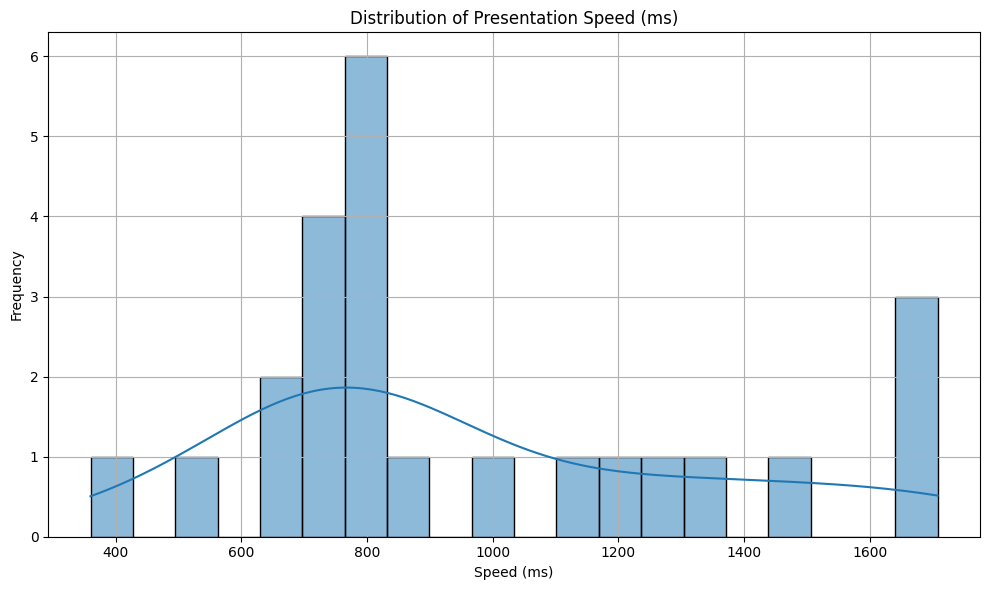

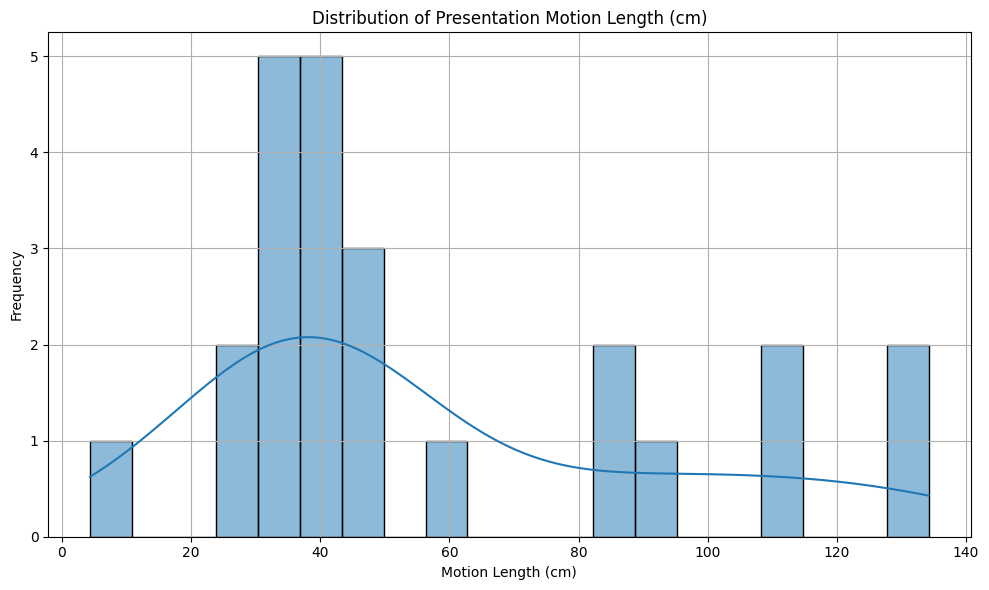

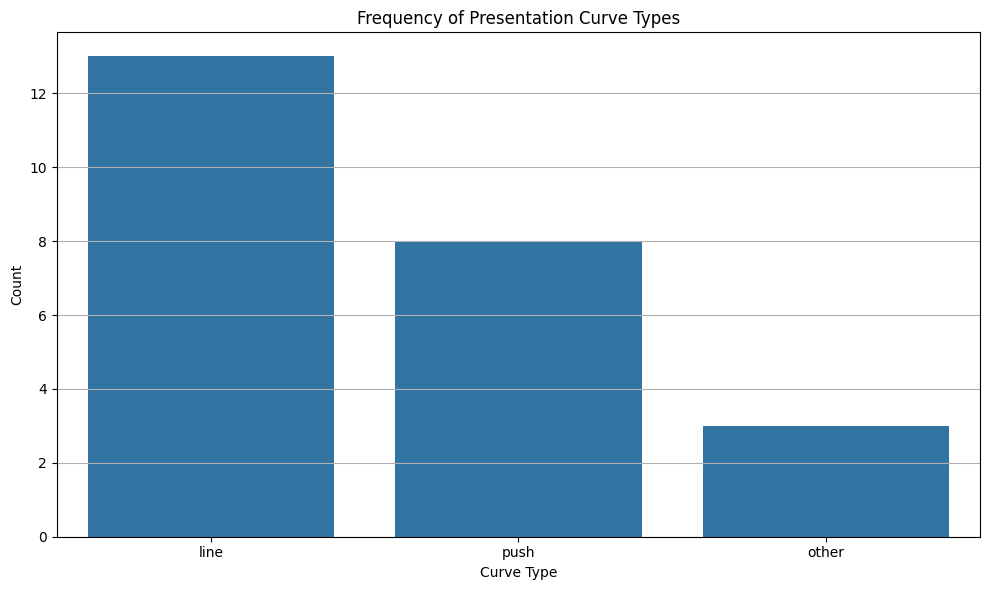

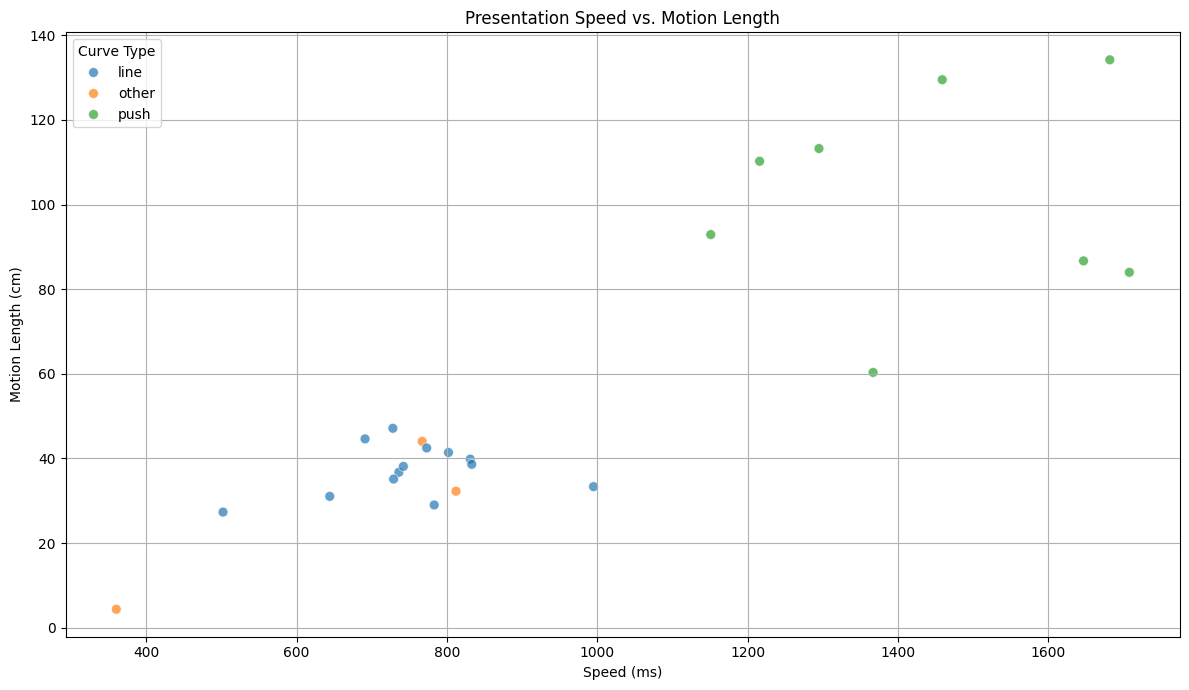

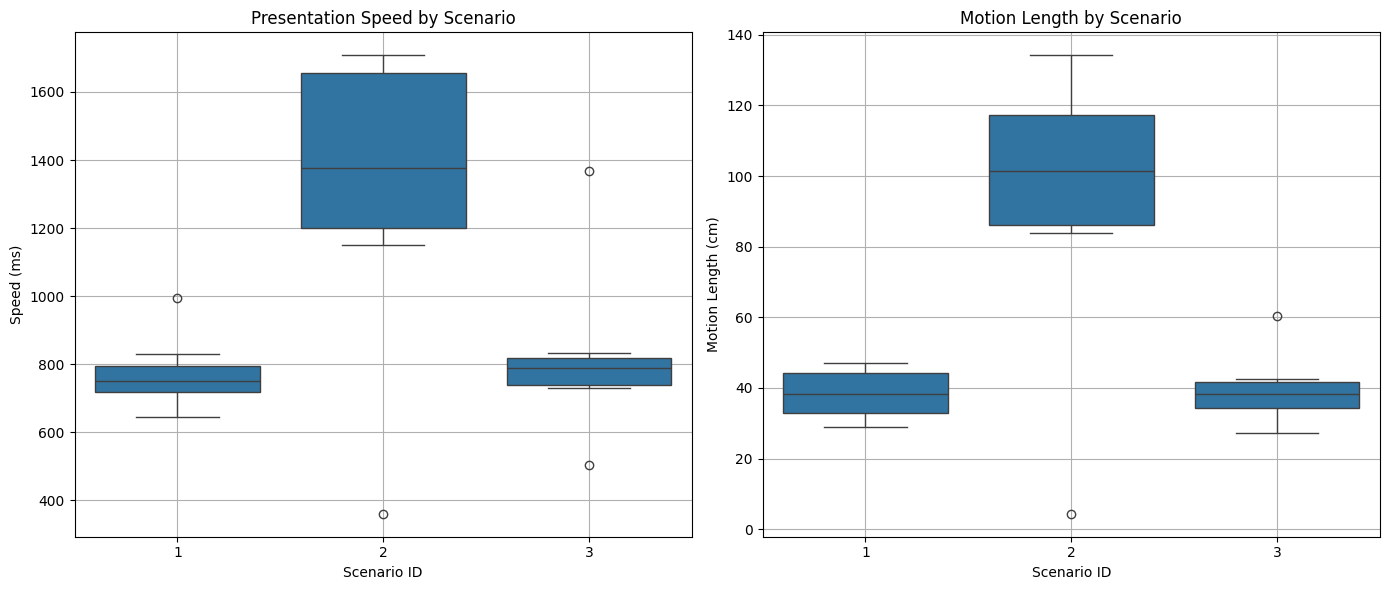

<Figure size 1200x700 with 0 Axes>

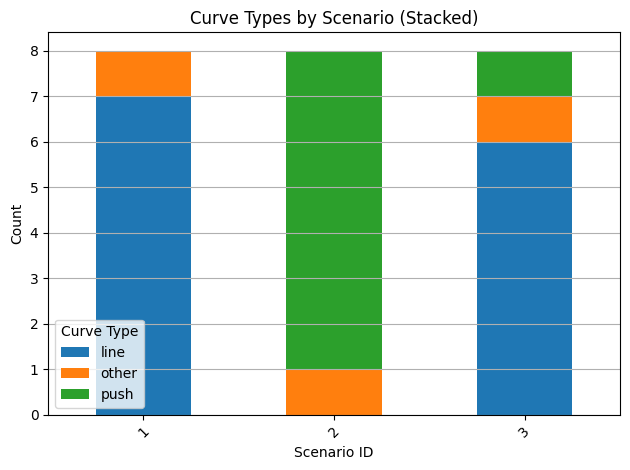

EDA plots generated and saved (if any).


In [42]:


def perform_exploratory_analysis(results_df):
    """
    Performs exploratory data analysis on the aggregated drill presentation metrics.
    Args:
        results_df (pd.DataFrame): DataFrame containing metrics from all scenarios and drills.
    """
    print("\n\n--- Exploratory Data Analysis ---")

    # Filter out rows where analysis might have failed or metrics are missing
    # We'll focus on successful analyses for these summary stats.
    valid_results = results_df.dropna(subset=['speed_ms', 'motion_length_cm', 'curve_type']).copy()
    valid_results = valid_results[valid_results['error'].isnull()] # Only where no error reported

    if valid_results.empty:
        print("No valid results available for EDA after filtering errors/NaNs.")
        return

    # --- 1. Distribution of Presentation Speed ---
    plt.figure(figsize=(10, 6))
    sns.histplot(valid_results['speed_ms'], kde=True, bins=20)
    plt.title('Distribution of Presentation Speed (ms)')
    plt.xlabel('Speed (ms)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("eda_plot_speed_distribution.png")
    plt.show()

    # --- 2. Distribution of Motion Length ---
    plt.figure(figsize=(10, 6))
    sns.histplot(valid_results['motion_length_cm'], kde=True, bins=20)
    plt.title('Distribution of Presentation Motion Length (cm)')
    plt.xlabel('Motion Length (cm)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("eda_plot_motion_distribution.png")
    plt.show()

    # --- 3. Frequency of Curve Types ---
    if 'curve_type' in valid_results.columns and not valid_results['curve_type'].empty:
        plt.figure(figsize=(10, 6))
        sns.countplot(x='curve_type', data=valid_results, order=valid_results['curve_type'].value_counts().index)
        plt.title('Frequency of Presentation Curve Types')
        plt.xlabel('Curve Type')
        plt.ylabel('Count')
        plt.grid(axis='y')
        plt.tight_layout()
        plt.savefig("eda_plot_curve_type_frequency.png")
        plt.show()
    else:
        print("Skipping curve type frequency plot: 'curve_type' column missing or empty.")


    # --- 4. Speed vs. Motion Length ---
    if 'curve_type' in valid_results.columns:
        plt.figure(figsize=(12, 7))
        sns.scatterplot(x='speed_ms', y='motion_length_cm', hue='curve_type', data=valid_results, alpha=0.7, s=50)
        plt.title('Presentation Speed vs. Motion Length')
        plt.xlabel('Speed (ms)')
        plt.ylabel('Motion Length (cm)')
        plt.legend(title='Curve Type')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("eda_plot_speed_vs_motion.png")
        plt.show()
    else: # Fallback if no curve_type
        plt.figure(figsize=(12, 7))
        sns.scatterplot(x='speed_ms', y='motion_length_cm', data=valid_results, alpha=0.7, s=50)
        plt.title('Presentation Speed vs. Motion Length')
        plt.xlabel('Speed (ms)')
        plt.ylabel('Motion Length (cm)')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("eda_plot_speed_vs_motion_no_hue.png")
        plt.show()


    # --- 5. Comparison of Metrics Across Scenarios ---
    if 'scenario_id' in valid_results.columns and valid_results['scenario_id'].nunique() > 1:
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        sns.boxplot(x='scenario_id', y='speed_ms', data=valid_results)
        plt.title('Presentation Speed by Scenario')
        plt.xlabel('Scenario ID')
        plt.ylabel('Speed (ms)')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        sns.boxplot(x='scenario_id', y='motion_length_cm', data=valid_results)
        plt.title('Motion Length by Scenario')
        plt.xlabel('Scenario ID')
        plt.ylabel('Motion Length (cm)')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("eda_plot_metrics_by_scenario_boxplot.png")
        plt.show()

        if 'curve_type' in valid_results.columns:
            plt.figure(figsize=(12, 7))
            # Create a pivot table for stacked bar chart
            scenario_curve_counts = valid_results.groupby(['scenario_id', 'curve_type']).size().unstack(fill_value=0)
            if not scenario_curve_counts.empty:
                scenario_curve_counts.plot(kind='bar', stacked=True)
                plt.title('Curve Types by Scenario (Stacked)')
                plt.xlabel('Scenario ID')
                plt.ylabel('Count')
                plt.legend(title='Curve Type')
                plt.xticks(rotation=45)
                plt.grid(axis='y')
                plt.tight_layout()
                plt.savefig("eda_plot_curve_types_by_scenario_stacked.png")
                plt.show()
            else:
                print("Not enough data to plot curve types by scenario (stacked).")

    elif 'scenario_id' in valid_results.columns:
        print("Only one scenario ID found. Skipping scenario comparison plots.")
    else:
        print("Skipping scenario comparison plots: 'scenario_id' column missing.")


    print("EDA plots generated and saved (if any).")


if 'final_results_df' in locals() and not final_results_df.empty:
    perform_exploratory_analysis(final_results_df)
else:
    print("final_results_df is not defined or is empty. Skipping EDA.")

In [29]:
# # --- MAIN PROCESSING LOOP ---
# drill_metrics_results = []
# WEAPON_POS_COLS = ['weapon_muzzle_position_x', 'weapon_muzzle_position_y', 'weapon_muzzle_position_z']

# # Define all thresholds in one place
# ALL_THRESHOLDS = {
#     'windowing': {
#         'MOVEMENT_VELOCITY_THRESHOLD': 0.15, # m/s
#         'SUSTAINED_MOVEMENT_FRAMES': 3,
#         'MIN_Y_LIFT_FOR_START': 0.03, # meters
#         'STABILIZATION_VELOCITY_THRESHOLD': 0.1, # m/s
#         'SUSTAINED_STABILIZATION_FRAMES': 3,
#     },
#   'curve': {
#         'LINE_RATIO_THRESHOLD': 1.15,
#         'MAX_WOBBLE_DEVIATION_M': 0.05, # NEW: e.g., 5cm max deviation from 3D line for "line" type
#         'VERTICAL_DEVIATION_THRESHOLD_M': 0.05, # NEW: e.g., 5cm for Y deviation
#         'LATERAL_DEVIATION_THRESHOLD_M': 0.05,  # NEW: e.g., 5cm for X deviation

#     }
# }

# PLOT_OUTPUT_DIR = "drill_presentation_plots"

# for drill_uid, drill_data in drills_for_analysis.items():
#     T_drill_start = drill_data['start_time']
#     T_first_shot = drill_data.get('first_shot')

#     print(f"\nProcessing Drill: {drill_uid} (Event Start: {T_drill_start}, Event First Shot: {T_first_shot})")

#     if T_first_shot is None:
#         error_msg = "Missing T_first_shot"
#     elif T_first_shot <= T_drill_start:
#         error_msg = "T_first_shot not after T_drill_start"
#     else:
#         error_msg = None

#     if error_msg:
#         print(f"  Skipping: {error_msg}")
#         drill_metrics_results.append({"drill_uid": drill_uid, "error": error_msg})
#         continue

#     current_drill_frames_segment = frame_df[
#         (frame_df['timestamp'] >= T_drill_start) &
#         (frame_df['timestamp'] < T_first_shot)
#     ].copy()

#     if current_drill_frames_segment.empty or len(current_drill_frames_segment) < 2:
#         print(f"  Skipping: Not enough frame data between T_drill_start and T_first_shot.")
#         drill_metrics_results.append({"drill_uid": drill_uid, "error": "Insufficient frame data for drill period"})
#         continue

#     speed, motion, curve, T_start_calc, T_end_calc, trajectory_df_for_plot  = analyze_single_drill_presentation(
#         current_drill_frames_segment, WEAPON_POS_COLS, T_drill_start, ALL_THRESHOLDS
#     )

#     if speed is not None: # Check if analysis was successful
#         drill_metrics_results.append({
#             "drill_uid": drill_uid,
#             "T_drill_start_event": T_drill_start, "T_first_shot_event": T_first_shot,
#             "T_presentation_start_calc": T_start_calc, "T_presentation_end_calc": T_end_calc,
#             "speed_ms": speed, "motion_length_cm": motion, "curve_type": curve, "error": None
#         })
#        # Plot if successful and trajectory data is available
#         if not trajectory_df_for_plot.empty:
#             plot_drill_presentation(drill_uid, trajectory_df_for_plot, T_start_calc, T_end_calc, WEAPON_POS_COLS, curve, PLOT_OUTPUT_DIR)
#         else:
#             print(f"  Presentation analysis failed for Drill {drill_uid}.")
#     else:
#         drill_metrics_results.append({
#             "drill_uid": drill_uid,
#             "T_drill_start_event": T_drill_start, "T_first_shot_event": T_first_shot,
#              "T_presentation_start_calc": T_start_calc, "T_presentation_end_calc": T_end_calc, # Store even if partial
#             "error": "Presentation analysis failed (e.g., no start/end found or trajectory too short)"
#         })



Processing Drill: Assessment/head_shot (Event Start: 1732538217548, Event First Shot: 1732538220618)
  Analysis Results: Speed=995ms, Motion=33.33cm, Curve=line, PresStart=1732538218608, PresEnd=1732538219603
  Plot saved: drill_presentation_plots/drill_Assessment_head_shot_presentation.png

Processing Drill: Assessment/double_tap (Event Start: 1732538230160, Event First Shot: 1732538232140)
  Analysis Results: Speed=831ms, Motion=39.83cm, Curve=line, PresStart=1732538230964, PresEnd=1732538231795
  Plot saved: drill_presentation_plots/drill_Assessment_double_tap_presentation.png

Processing Drill: Assessment/failure (Event Start: 1732538241360, Event First Shot: 1732538243621)
  Analysis Results: Speed=691ms, Motion=44.61cm, Curve=line, PresStart=1732538242422, PresEnd=1732538243113
  Plot saved: drill_presentation_plots/drill_Assessment_failure_presentation.png

Processing Drill: Assessment/reload (Event Start: 1732538252950, Event First Shot: 1732538254761)
  Analysis Results: Spee

from here on old code (works but not divided to functions:

In [ ]:
# # --- WEAPON PRESENTATION ANALYSIS FUNCTION ---
# def analyze_weapon_presentation(drill_frames_segment, weapon_pos_cols, T_first_shot_drill):
#     """
#     Analyzes a segment of frame data for a single drill's weapon presentation.

#     Args:
#         drill_frames_segment (pd.DataFrame): DataFrame containing frames for the current drill,
#                                              from T_drill_start up to (but not including) T_first_shot.
#                                              Must include 'timestamp' and weapon_pos_cols.
#         weapon_pos_cols (list): List of column names for weapon X, Y, Z positions.
#         T_first_shot_drill (int): Timestamp of the first shot for this drill.

#     Returns:
#         tuple: (speed_ms, motion_length_cm, curve_type, T_pres_start, T_pres_end) or None if analysis fails.
#     """
#     if drill_frames_segment.empty or len(drill_frames_segment) < 2:
#         print("  Analysis: Not enough frame data for this drill segment.")
#         return None

#     df = drill_frames_segment.copy() # Work on a copy

#     # 2. Calculate weapon velocity
#     pos_diff = df[weapon_pos_cols].diff()
#     time_diff_ms = df['timestamp'].diff()
#     time_diff_s = time_diff_ms / 1000.0 # Convert ms to s

#     # Handle first row NaN and potential zero time diffs
#     pos_diff.iloc[0] = 0
#     time_diff_s.iloc[0] = 1.0 # Avoid division by zero, effectively zero velocity for first frame
#     time_diff_s[time_diff_s == 0] = 1e-6 # Replace 0s with very small number to avoid div by zero

#     velocity_xyz = pos_diff.divide(time_diff_s.values.reshape(-1, 1), axis=0)
#     df['velocity_mag'] = np.linalg.norm(velocity_xyz.values, axis=1) #Calculates the magnitude of the 3D velocity vector for each frame
#     df.iloc[0, df.columns.get_loc('velocity_mag')] = 0 # Ensure first frame velocity is 0


#     # 3. Find T_pres_start (start of sustained movement)
#     T_pres_start = None
#     idx_pres_start = -1
#     initial_y_position_at_drill_start = df.iloc[0][weapon_pos_cols[1]] # Y at T_drill_start

#     for i in range(len(df) - SUSTAINED_MOVEMENT_FRAMES + 1):
#         current_segment = df.iloc[i : i + SUSTAINED_MOVEMENT_FRAMES]

#         # Check for sustained movement above threshold
#         if not (current_segment['velocity_mag'] >= MOVEMENT_VELOCITY_THRESHOLD).all():
#             continue

#         # Check if it's a significant lift and not returning to idle immediately after
#         y_at_potential_start = df.iloc[i][weapon_pos_cols[1]]
#         y_at_end_of_sustained_move = df.iloc[i + SUSTAINED_MOVEMENT_FRAMES - 1][weapon_pos_cols[1]]

#         # Check general upward trend during sustained movement (Y-coord for weapon_pos_cols[1])
#         avg_vy = velocity_xyz.iloc[i : i + SUSTAINED_MOVEMENT_FRAMES][weapon_pos_cols[1]].mean()

#         if (y_at_potential_start >= initial_y_position_at_drill_start + MIN_Y_LIFT_FOR_START or \
#             y_at_end_of_sustained_move >= initial_y_position_at_drill_start + MIN_Y_LIFT_FOR_START) and \
#            avg_vy > 0.01 : # Ensure some net upward velocity component

#             # Check if it drops back to idle in the next few frames (anti-twitch)
#             drops_back = False
#             check_further_frames = min(len(df), i + SUSTAINED_MOVEMENT_FRAMES + 3)
#             for k in range(i + SUSTAINED_MOVEMENT_FRAMES, check_further_frames):
#                 if df.iloc[k][weapon_pos_cols[1]] < initial_y_position_at_drill_start + (MIN_Y_LIFT_FOR_START / 2):
#                     drops_back = True
#                     break
#             if not drops_back:
#                 idx_pres_start = df.index[i] # Use original DataFrame index
#                 T_pres_start = df.loc[idx_pres_start, 'timestamp']
#                 break

#     if T_pres_start is None:
#         print("  Analysis: Could not determine presentation_start.")
#         return None

#       # 4. Find T_pres_end (stabilization before T_first_shot)
#     T_pres_end = None
#     idx_pres_end = -1

#     # Search from pres_start up to (but not including) T_first_shot
#     # The input df is already filtered up to T_first_shot
#     search_df_for_end = df[df['timestamp'] >= T_pres_start].copy()

#     if len(search_df_for_end) < SUSTAINED_STABILIZATION_FRAMES:
#          print("  Analysis: Not enough frames after T_pres_start to determine T_pres_end.")
#          # Default to last frame before shot if not enough data for stabilization check
#          if not search_df_for_end.empty:
#             idx_pres_end = search_df_for_end.index[-1]
#             T_pres_end = search_df_for_end.loc[idx_pres_end, 'timestamp']
#          else: # T_pres_start was the last frame
#             return None # Cannot form a trajectory
#     else:
#         for i in range(len(search_df_for_end) - SUSTAINED_STABILIZATION_FRAMES + 1):
#             current_segment = search_df_for_end.iloc[i : i + SUSTAINED_STABILIZATION_FRAMES]
#             if (current_segment['velocity_mag'] <= STABILIZATION_VELOCITY_THRESHOLD).all():
#                 idx_pres_end = current_segment.index[0] # Start of stabilization period
#                 T_pres_end = search_df_for_end.loc[idx_pres_end, 'timestamp']
#                 break

#     if T_pres_end is None: # If no clear stabilization, use the last frame before T_first_shot
#         if not search_df_for_end.empty:
#             idx_pres_end = search_df_for_end.index[-1]
#             T_pres_end = search_df_for_end.loc[idx_pres_end, 'timestamp']
#         else: # Should not happen if T_pres_start was found
#             print("  Analysis: T_pres_end search yielded no frames.")
#             return None

#     if T_pres_end <= T_pres_start:
#         print(f"  Analysis: presentation_end ({T_pres_end}) is not after presentation_start ({T_pres_start}).")
#         # If T_pres_end is the same as T_pres_start, consider if it's valid or an error
#         # For now, let's assume it needs at least one frame difference.
#         if len(df[df['timestamp'] > T_pres_start]) > 0: # If there are frames after T_pres_start
#              idx_pres_end = df[df['timestamp'] > T_pres_start].index[0]
#              T_pres_end = df.loc[idx_pres_end, 'timestamp']
#         else: # no frames after T_pres_start up to T_first_shot
#              return None

#     # 5. Extract trajectory between T_pres_start and T_pres_end
#     trajectory_df = df[(df['timestamp'] >= T_pres_start) & (df['timestamp'] <= T_pres_end)]

#     if len(trajectory_df) < 2:
#         print(f"  Analysis: Not enough trajectory points ({len(trajectory_df)}) between T_pres_start and T_pres_end.")
#         return None


#     # 6. Calculate Metrics
#     # Metric 1: Speed (ms)
#     speed_ms = T_pres_end - T_pres_start

#     # Metric 2: Motion (cm)
#     motion_length_m = 0.0
#     positions = trajectory_df[weapon_pos_cols].values
#     for i in range(len(positions) - 1):
#         p1 = positions[i]
#         p2 = positions[i+1]
#         motion_length_m += euclidean(p1, p2)
#     motion_length_cm = motion_length_m * 100.0

#     curve_type = classify_presentation_curve(
#     trajectory_df, weapon_pos_cols, motion_length_m, direct_dist_m, all_thresholds['curve']
# )

#     #placeholders:
#     curve_type = 'unknown'

#     print(f"  Analysis Results: Speed={speed_ms:.0f}ms, Motion={motion_cm:.2f}cm, Curve={curve_type}, PresStart={T_pres_start}, PresEnd={T_pres_end}")
#     return speed_ms, motion_length_cm, curve_type, T_pres_start, T_pres_end

In [ ]:
# # --- MAIN PROCESSING LOOP ---
# drill_metrics_results = []


# for drill_data in drills_data_map:
#     drill_uid = drill_data
#     T_drill_start = drills_data_map[drill_data]['start_time']
#     T_first_shot = drills_data_map[drill_data].get('first_shot')

#     print(f"\nProcessing Drill: {drill_uid} (Event Start: {T_drill_start}, Event First Shot: {T_first_shot})")

#     if T_first_shot is None:
#         print(f"  Skipping presentation analysis for Drill {drill_uid}: Missing T_first_shot.")
#         drill_metrics_results.append({
#             "drill_uid": drill_uid, "error": "Missing T_first_shot"
#         })
#         continue

#     if T_first_shot <= T_drill_start:
#         print(f"  Skipping presentation analysis for Drill {drill_uid}: T_first_shot ({T_first_shot}) is not after T_drill_start ({T_drill_start}).")
#         drill_metrics_results.append({
#             "drill_uid": drill_uid, "error": "T_first_shot not after T_drill_start"
#         })
#         continue

#     # 1. Filter `frame_df` for rows between T_drill_start and T_first_shot (exclusive of T_first_shot)
#     current_drill_frames = frame_df[
#         (frame_df['timestamp'] >= T_drill_start) &
#         (frame_df['timestamp'] < T_first_shot)
#     ].copy()

#     if current_drill_frames.empty or len(current_drill_frames) < 2 : # Need at least 2 frames for diff
#         print(f"  Skipping presentation analysis for Drill {drill_uid}: Not enough frame data between T_drill_start and T_first_shot.")
#         drill_metrics_results.append({
#             "drill_uid": drill_uid, "error": "Insufficient frame data for drill period"
#         })
#         continue

#     analysis_result = analyze_weapon_presentation(current_drill_frames, WEAPON_POS_COLS, T_first_shot)

#     if analysis_result:
#         speed_ms, motion_cm, curve_type, T_pres_start, T_pres_end = analysis_result
#         drill_metrics_results.append({
#             "drill_uid": drill_uid,
#             "T_drill_start_event": T_drill_start,
#             "T_first_shot_event": T_first_shot,
#             "T_presentation_start_calc": T_pres_start,
#             "T_presentation_end_calc": T_pres_end,
#             "speed_ms": speed_ms,
#             "motion_length_cm": motion_cm,
#             "curve_type": curve_type,
#             "error": None
#         })
#     else:
#         print(f"  Presentation analysis failed for Drill {drill_uid}.")
#         drill_metrics_results.append({
#             "drill_uid": drill_uid,
#             "T_drill_start_event": T_drill_start,
#             "T_first_shot_event": T_first_shot,
#             "error": "Presentation analysis failed"
#         })



Processing Drill: Assessment/head_shot (Event Start: 1732538217548, Event First Shot: 1732538220618)
  Analysis Results: Speed=1994ms, Motion=41.29cm, Curve=unknown, PresStart=1732538218608, PresEnd=1732538220602

Processing Drill: Assessment/double_tap (Event Start: 1732538230160, Event First Shot: 1732538232140)
  Analysis Results: Speed=1159ms, Motion=42.46cm, Curve=unknown, PresStart=1732538230964, PresEnd=1732538232123

Processing Drill: Assessment/failure (Event Start: 1732538241360, Event First Shot: 1732538243621)
  Analysis Results: Speed=1184ms, Motion=48.72cm, Curve=unknown, PresStart=1732538242422, PresEnd=1732538243606

Processing Drill: Assessment/reload (Event Start: 1732538252950, Event First Shot: 1732538254761)
  Analysis Results: Speed=1095ms, Motion=50.01cm, Curve=unknown, PresStart=1732538253650, PresEnd=1732538254745

Processing Drill: Assessment/forty_five (Event Start: 1732538264717, Event First Shot: 1732538267040)
  Analysis Results: Speed=1273ms, Motion=40.7